In [1]:
import pandas as pd
import numpy as np
import pygad as pg
import deap as dp
import random
from deap import base, creator, tools, gp, algorithms
import time
import matplotlib.pyplot as plt

In [2]:
oferta = pd.read_csv('oferta.csv')
asignaturas = pd.read_csv('asignaturas.csv')
formato_cargas = pd.read_csv('formato_cargas.csv')
plan_2016 = pd.read_csv('plan_2016.csv')
seriaciones = pd.read_csv('../seriacion.csv')

# Definición de funciones útiles

In [3]:
matriculas = formato_cargas.query('n_matricula > 160000000')['n_matricula'].unique()

## Función para obtener un Kardex aleatorio

In [4]:
def obtenerKardex(mat = -1):
    if(mat == -1):
        mat = np.random.choice(matriculas)
    return formato_cargas.query('n_matricula == ' + str(mat)).sort_values('periodo')

In [5]:
def obtenerCreditos(kardex):
    claves = kardex.query('promediofinal >= 7')['clave'].unique()
    totalCreditos = 0
    for clave in claves:
        if(clave[0:2] == 'LI' or clave[0:2] == 'TA' or clave[0:2] == 'AD'):
            continue
        totalCreditos += plan.query('clave == "' + clave + '"')['creditos'].values[0]
    return totalCreditos

In [6]:
def obtenerRecomendacionesUnicas(recomendaciones,umbral):
    recomendacionesFinal = []
    for rec in recomendaciones:
        recomendacionesFinal.append(list(set(rec)))
    recomendacionesFinal = list(np.unique(recomendacionesFinal))
    recomendacionesFinal.sort(key=lambda x: -obtenerDesempeno(x))

    return recomendacionesFinal

In [7]:
def verKardex():
    print('Matricula: ' + str(kardex.iloc[0]['n_matricula']))
    print('Carrera: ' + str(kardex.iloc[0]['carrera']))
    print('Creditos: ' + str(obtenerCreditos(kardex))) 
    print('Materias Reprobadas:')
    for clave in obtenerMateriasReprobadas(kardex):
        print('\t' + clave,plan.query('clave == "' + clave + '"')['nombre'].values[0])
    print('\n')
    periodos = kardex['periodo'].unique()
    for per in periodos:
        print('Periodo: ' + str(per))
        print('Clave\t\tPromedio\tNombre de asignatura')
        materias = kardex.query('periodo == ' + str(per))
        for i in range(len(materias)):
            if(materias.iloc[i]['promediofinal'] < 7):
                print('* ' + materias.iloc[i]['clave'] + '\t' + str(materias.iloc[i]['promediofinal']) + '\t\t' + materias.iloc[i]['asignatura'])
            else:
                print(materias.iloc[i]['clave'] + '\t\t' + str(materias.iloc[i]['promediofinal']) + '\t\t' + materias.iloc[i]['asignatura'])
        print('\n')
    

## Obtención de oferta útil

In [8]:
def materiaHaSidoAprobada(kardex,clave):
    if len(kardex.query('clave == "' + clave + '" and promediofinal >= 7')) == 0:
        return False
    else:
        return True

In [9]:
def respetaSeriacion(clave,kardex):
    if len(seriaciones.query('ser2 == "' + clave + '"')) == 0:
        return True
    else:
        #Se guarda en necesarias la lista de asignaturas necesarias para llevar la asignura "clave"
        necesarias = seriaciones.query('ser2 == "' + clave + '"')['ser1'].unique()
        
        #Se recorre la lista para comprobar si el estudiante ya pasó las asignaturas necesarias, en caso de que le falte 
        #al menos una, entonces no se respeta la seriación.
        for necesaria in necesarias:
            if not(materiaHaSidoAprobada(kardex,necesaria)):
                return False
        return True

In [10]:
#Filtra las materias que no cumplen las restricciones 1 y 2

def obtenerOfertaUtil(kardex,oferta):
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    
    #Se eliminan las materias en la oferta que ya han sido aprobadas
    aprobadas = kardex.query('promediofinal >= 7')['clave'].unique()
    for clave in aprobadas:
        oferta = oferta.query('clave != "' + clave + '"')
        
    #Se eliminan las materias que el alumno no puede llevar por la seriación
    ofertaUtilIndex = set(oferta.index.values)
    for idx in oferta.index:
        if not(respetaSeriacion(oferta.loc[idx]['clave'],kardex)):
            ofertaUtilIndex.remove(idx)
            
    #Se eliminan prácticas profesionales y proyecto terminal
    for i in range(len(oferta['clave'].values)):
        clave = oferta['clave'].values[i]
        if clave[0:3] == 'PID' or clave == 'IT0427':
            try:
                ofertaUtilIndex.remove(oferta.index.values[i])
            except:
                continue
    ofertaUtil = oferta.loc[list(ofertaUtilIndex)]
    
    ofertaUtil = pd.merge(ofertaUtil,plan,how='left',on='clave')[['clave','ciclos','Nombre','Maestro','Lunes','Martes','Miercoles','Jueves','Viernes']]
    
    #Se eliminan materias de elección libre de primer y segundo ciclo
    if(materiaHaSidoAprobada(kardex,'IL0102')):
        ofertaUtil = ofertaUtil.query('clave != "ID0160"')
    if(materiaHaSidoAprobada(kardex,'ID0160')):
        ofertaUtil = ofertaUtil.query('clave != "IL0102"')
    
    if(materiaHaSidoAprobada(kardex,'IT0103')):
        ofertaUtil = ofertaUtil.query('clave != "ID0161"')
    if(materiaHaSidoAprobada(kardex,'ID0161')):
        ofertaUtil = ofertaUtil.query('clave != "IT0103"')
        
    if(materiaHaSidoAprobada(kardex,'ID0264')):
        ofertaUtil = ofertaUtil.query('clave != "ID0262"')
    if(materiaHaSidoAprobada(kardex,'ID0262')):
        ofertaUtil = ofertaUtil.query('clave != "ID0264"')
        
    if(materiaHaSidoAprobada(kardex,'ID0263')):
        ofertaUtil = ofertaUtil.query('clave != "ID0265"')
    if(materiaHaSidoAprobada(kardex,'ID0265')):
        ofertaUtil = ofertaUtil.query('clave != "ID0263"')
        
    #Si la disponibilidad de horario es una restricción, entonces elimina las materias que violen la restricción
    if(disponibilidadComoRestriccion):
        indices = set(ofertaUtil.index)
        indicesUtiles = indices.copy()
        for dia in dias:
            for i in indices:
                if ofertaUtil.loc[i][dia] == '-':
                    continue
                
                horaInicio = int(ofertaUtil.loc[i][dia][0:2])
                horaFin = int(ofertaUtil.loc[i][dia][6:8])
                
                for hora in range(horaInicio,horaFin):
                    if not(disponibilidad.query('hora == ' + str(hora))[dia].values[0]):
                        if i in indicesUtiles:
                            indicesUtiles.remove(i)
        indicesUtiles = list(indicesUtiles)
        ofertaUtil = ofertaUtil.loc[indicesUtiles]
    
    return ofertaUtil

## Generación de carga aleatoria válida

En esta sección creamos las funciones "generarCargaValida" la cual retorna una string de bits representando una carga académica con base a la oferta útil. También se crea la función "obtenerDatosCarga" que nos ayuda a obtener los datos de una carga académica con base a la oferta útil y a una string de bits que denominamos "bits de carga"

In [11]:
def generarSolucionAleatoria(ofertaUtil):
    solucion = [-1] * 9
    for i in range(9):
        gen = np.random.randint(-1,len(ofertaUtil))
        if gen == -1:
            solucion[i] = -1
        else:
            solucion[i] = ofertaUtil.index[gen]
    return solucion

In [12]:
def obtenerDatosCarga(solucion):
    solucionU = np.array(solucion)
    solucionU = np.unique(solucionU)
    solucionU = solucionU[solucionU >= 0]
    
    return ofertaUtil.loc[solucionU]

In [13]:
def comprobarTraslapacion(solucion,ofertaUtil):
    datosCarga = obtenerDatosCarga(solucion)
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    
    for dia in dias:
        horarioDia = datosCarga.sort_values(dia)[dia].values
        for i in range(len(horarioDia)):
            if horarioDia[i] == '-':
                continue
            horaInicioI = int(horarioDia[i][0:2])
            horaFinI = int(horarioDia[i][6:8])
            
            for j in range(i+1,len(horarioDia)):
                horaInicioJ = int(horarioDia[j][0:2])
                horaFinJ = int(horarioDia[j][6:8])
                
                if not(horaFinJ  <= horaInicioI or horaInicioJ >= horaFinI):
                    return True
    return False

In [14]:
def esValido(solucion,ofertaUtil):
    #Si se repite una materia es inválido
    datosCarga = obtenerDatosCarga(solucion)
    if len(datosCarga['clave'].unique()) < len(datosCarga):
        return False
    #Si se traslapan dos materias es inválido
    if comprobarTraslapacion(solucion,ofertaUtil):
        return False
    #Si son menos de 3 materias es inválido
    solucionSet = set(solucion)
    if -1 in solucionSet:
        solucionSet.remove(-1)
    if(len(solucionSet)<3):
        return False
    
    #Si se llevan dos materias de elección libre del ciclo 1 y 2
    clavesSet = set(datosCarga['clave'])
    
    if 'IL0102' in clavesSet and 'ID0160' in clavesSet:
        return False
    if 'IT0103' in clavesSet and 'ID0161' in clavesSet:
        return False
    if 'ID0264' in clavesSet and 'ID0262' in clavesSet:
        return False
    if 'ID0263' in clavesSet and 'ID0265' in clavesSet:
        return False
    
    return True

In [15]:
def generarSolucionValida(ofertaUtil):
    bitsDeCarga = generarSolucionAleatoria(ofertaUtil)
    
    while not(esValido(bitsDeCarga,ofertaUtil)):
        bitsDeCarga = generarSolucionAleatoria(ofertaUtil)
    
    return bitsDeCarga

In [16]:
def obtenerHorario(carga):
    primeraHoraMinima = 24
    ultimaHoraMaxima = 0
    datosCarga = obtenerDatosCarga(carga)
    horario = pd.DataFrame({
        'Hora': ['7:00-8:00','8:00-9:00','9:00-10:00','10:00-11:00','11:00-12:00','12:00-13:00','13:00-14:00','14:00-15:00','15:00-16:00','16:00-17:00','17:00-18:00','18:00-19:00','19:00-20:00','20:00-21:00','21:00-22:00'],
        'Lunes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Martes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Miercoles': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Jueves': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Viernes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
    })
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    for dia in dias:
        for i in range(len(datosCarga)):
            if datosCarga[dia].iloc[i] == '-':
                continue

            horaInicio = int(datosCarga.iloc[i][dia][0:2])
            horaFin = int(datosCarga.iloc[i][dia][6:8])
            
            primeraHoraMinima = min(primeraHoraMinima,horaInicio)
            ultimaHoraMaxima = max(ultimaHoraMaxima,horaFin)
            
            nombre = datosCarga.iloc[i]['Nombre']

            for hora in range(horaInicio,horaFin):
                horario.loc[hora-7,dia]=nombre
    return horario[(primeraHoraMinima-7):(ultimaHoraMaxima-6)]

# Definición de funciones de utilidad y de costo

## Utilidad de carga académica con base en cantidad ideal de materias

In [17]:
def UpCM(solucion):
    if(cantidadMateriasIdeal == 0):
        return 1
    
    diferenciaMaxima = max(cantidadMateriasIdeal-3,9-cantidadMateriasIdeal)
    solucionSet = set(solucion)
    
    if -1 in solucionSet:
        solucionSet.remove(-1)
        
    tamanoCarga = len(solucionSet)
    separacion = abs(tamanoCarga-cantidadMateriasIdeal)
    
    return 1 - (separacion / diferenciaMaxima)

## Utilidad de carga académica con base en las materias reprobadas

In [18]:
def obtenerMateriasReprobadas(kardex):
    materiasReprobadas = kardex.query('promediofinal < 7')['clave'].unique()
    materiasReprobadasFinal = []
    for clave in materiasReprobadas:
        aprobado = len(kardex.query('clave == "' + clave + '" and promediofinal >= 7'))
        if aprobado == 0 and clave[0:2] != 'LI':
            materiasReprobadasFinal.append(clave)
    return materiasReprobadasFinal

In [19]:
def UpMR(kardex,solucion,ofertaUtil):
    materiasReprobadas = obtenerMateriasReprobadas(kardex)
    if len(materiasReprobadas) == 0:
        return 1
    datosCarga = obtenerDatosCarga(solucion)
    utilidadTotal = 0
    
    for clave in materiasReprobadas:
        cargado = len(datosCarga.query('clave == "' + clave + '"'))
        if cargado == 1:
            utilidadTotal += 1
            
    
    #Normalización
    utilidad = (utilidadTotal)/(len(materiasReprobadas))
    return utilidad

## Utilidad de carga académica con base en el cierre de ciclos

In [20]:
def UpCC(solucion,ofertaUtil):
    base = 3
    utilidad = [base**3,base**2,base,1]
    utilidadTotal = 0
    
    menorCiclo = min(ofertaUtil['ciclos']) - 1
    
    datosCarga = obtenerDatosCarga(solucion)
    
    claves = datosCarga['clave'].unique()
    for i in range(len(claves)):
        if claves[i][0:2] == 'AD'or claves[i][0:2] == 'TA' or claves[i][0:2] == 'LI' or claves[i][0:2] == 'PI':
            continue
            
        ciclo = int(plan.query('clave == "' + claves[i] + '"')['ciclos']) - 1
        utilidadTotal += utilidad[ciclo - menorCiclo]
    
    utilidadMaxima = 0
    cantidadMateriasCiclo1 = len(ofertaUtil.query('ciclos == ' + str(menorCiclo+1))['clave'].unique())
    cantidadMateriasCiclo2 = len(ofertaUtil.query('ciclos == ' + str(menorCiclo+2))['clave'].unique())
    cantidadMateriasCiclo3 = len(ofertaUtil.query('ciclos == ' + str(menorCiclo+3))['clave'].unique())
    cantidadMateriasCiclo4 = len(ofertaUtil.query('ciclos == ' + str(menorCiclo+4))['clave'].unique())
    cantidadMateriasMaxima = 9
    
    m1 = m2 = m3 = m4 = 0
    
    if (cantidadMateriasMaxima - cantidadMateriasCiclo1) >= 0:
        m1 = cantidadMateriasCiclo1
        cantidadMateriasMaxima -= cantidadMateriasCiclo1
    else:
        m1 = 9
        cantidadMateriasMaxima = 0
    if (cantidadMateriasMaxima - cantidadMateriasCiclo2) >= 0:
        m2 = cantidadMateriasCiclo2
        cantidadMateriasMaxima -= cantidadMateriasCiclo2
    elif cantidadMateriasMaxima > 0:
        m2 = cantidadMateriasMaxima
        cantidadMateriasMaxima = 0
    if (cantidadMateriasMaxima - cantidadMateriasCiclo3) >= 0:
        m3 = cantidadMateriasCiclo3
        cantidadMateriasMaxima -= cantidadMateriasCiclo3
    elif cantidadMateriasMaxima > 0:
        m3 = cantidadMateriasMaxima
        cantidadMateriasMaxima = 0
    if (cantidadMateriasMaxima - cantidadMateriasCiclo4) >= 0:
        m4 = cantidadMateriasCiclo4
        cantidadMateriasMaxima -= cantidadMateriasCiclo4
    elif cantidadMateriasMaxima > 0:
        m4 = cantidadMateriasMaxima
        cantidadMateriasMaxima = 0
        
    
    utilidadMaxima = m1*utilidad[0] + m2*utilidad[1] + m3*utilidad[2] + m4*utilidad[3]
 
    #Normalización
    utilidadNorm = (utilidadTotal)/(utilidadMaxima)
    return utilidadNorm

## Costo por amplitud de horario

In [21]:
def CpAH(solucion):
    amplitudAceptable = 7
    
    datosCarga = obtenerDatosCarga(solucion)
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    horaMin = 21
    horaMax = 7
    
    for dia in dias:
        for hora in datosCarga[dia]:
            if hora == '-':
                continue
            horaMin = min(int(hora[0:2]),horaMin)
            horaMax = max(int(hora[6:8]),horaMax)
            
    amplitud = (horaMax - horaMin)
    if amplitud <= amplitudAceptable:
        return 0
    amplitud -= amplitudAceptable
    
    return amplitud / (15 - amplitudAceptable)

## Costo de carga académica con base en las horas libres

#### NOTA: Tomar en cuenta las horas libres por día

In [22]:
    def CpHL(solucion,ofertaUtil):
        dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
        costoTotal = 0
        hlMax = 0

        datosCarga = obtenerDatosCarga(solucion)

        for dia in dias:
            datosCarga = datosCarga.sort_values(dia)
            if datosCarga[dia].iloc[len(datosCarga)-2] == '-':
                continue

            ultimaHoraFin = 0
            for i in range(len(datosCarga)):
                if datosCarga.iloc[i][dia] == '-':
                    continue
                if ultimaHoraFin == 0:
                    ultimaHoraFin = int(datosCarga.iloc[i][dia][6:8])
                    primeraHoraDia = int(datosCarga.iloc[i][dia][0:2])
                    continue
                horaInicio = int(datosCarga.iloc[i][dia][0:2])
                costoTotal += (horaInicio - ultimaHoraFin)
                ultimaHoraFin = int(datosCarga.iloc[i][dia][6:8])
            hlMax += (ultimaHoraFin - primeraHoraDia - 2)

        if hlMax == 0:
            return 0
        #Normalización
        costo = (costoTotal)/(hlMax)
        return costo

## Costo de carga académica con base en la disponibilidad de horario del estudiante

Creamos 4 casos diferentes donde los estudiantes trabajan. Guardamos el horario de ocupación de los estudiantes en un dataframe por cada estudiante.

In [23]:
# El estudiante trabaja por las mañanas tiempo completo
disp_est_1 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Martes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Miercoles": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Jueves": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Viernes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
})


# El estudiante trabaja por las tardes tiempo completo
disp_est_2 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Martes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Miercoles": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Jueves": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Viernes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
})

# El estudiante trabaja por las mañanas medio tiempo
disp_est_3 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Martes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Miercoles": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Jueves": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Viernes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
})
# El estudiante trabaja por las tardes medio tiempo
disp_est_4 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Martes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Miercoles": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Jueves": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Viernes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
})
disp_est_5 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Martes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Miercoles": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Jueves": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Viernes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
})

In [24]:
disponibilidadArr = [disp_est_1,disp_est_2,disp_est_3,disp_est_4,disp_est_5]

In [25]:
def CpDH(solucion,ofertaUtil,disponibilidad):
    disponibilidadTotal = sum(disponibilidad['Lunes']) + sum(disponibilidad['Martes']) + sum(disponibilidad['Miercoles']) + sum(disponibilidad['Jueves']) + sum(disponibilidad['Viernes'])
    if disponibilidadTotal == 75:
        return 0
    
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes']
    datosCarga = obtenerDatosCarga(solucion)
    costoTotal = 0

    for dia in dias:
        for i in range(len(datosCarga)):
            if datosCarga[dia].iloc[i] == '-':
                continue

            horaInicio = int(datosCarga.iloc[i][dia][0:2])
            horaFin = int(datosCarga.iloc[i][dia][6:8])

            for hora in range(horaInicio,horaFin):
                if not(disponibilidad.query('hora == ' + str(hora))[dia].values[0]):
                    costoTotal += 1
                    
    #Normalización
    costo = (costoTotal)/(75 - disponibilidadTotal)
    return costo

# Definición de la función de desempeño

In [26]:
def obtenerDesempeno(solucion):
    if not(esValido(solucion,ofertaUtil)):
        return 0
    
    upcc = UpCC(solucion,ofertaUtil)
    upmr = UpMR(kardex,solucion,ofertaUtil)
    upcm = UpCM(solucion)
    cpdh = CpDH(solucion,ofertaUtil,disponibilidad)
    cpah = CpAH(solucion)
    
    utilidades = {
        "upcc": (upcc * pesos["upcc"]),
        "upmr": (upmr * pesos["upmr"]),
        "upcm": (upcm * pesos["upcm"]),
        "cpdh": pesos["cpdh"] - (cpdh * pesos["cpdh"]),
        "cpah": pesos["cpah"] - (cpah * pesos["cpah"]),
    }
    
    return sum(utilidades.values())

In [27]:
def evaluarSolucion(solucion):
    desempeno = obtenerDesempeno(solucion)
    if(desempeno == 0):
        print('Solución no válida')
        return
    
    upcc = UpCC(solucion,ofertaUtil)
    upmr = UpMR(kardex,solucion,ofertaUtil)
    upcm = UpCM(solucion)
    cpdh = CpDH(solucion,ofertaUtil,disponibilidad)
    cpah = CpAH(solucion)
    
    print("La carga evaluada tiene:")
    print("\t" + str(round(100*upcc,2)) + "% de utilidad por las materias de primeros ciclos llevadas.")
    print("\t" + str(round(100*upmr,2)) + "% del total de las materias reprobadas del estudiante.") 
    print("\t" + str(round(100*upcm,2)) + "% de utilidad por cantidad ideal de materias del estudiante.") 
    print("\t" + str(round(100*cpdh,2)) + "% de costo por sobreposición con las horas donde el estudiante no está disponible.")
    print("\t" + str(round(100*cpah,2)) + "% de costo por el total de amplitud de horario.")

In [28]:
def on_generation(ga_instance):
    print("Generación: " + str(ga_instance.generations_completed))

In [29]:
def obtenerClase():
    gen = np.random.randint(-1,len(ofertaUtil))
    if gen == -1:
        clase = -1
    else:
        clase = ofertaUtil.index[gen]
        
    return clase

In [30]:
def mutacionUniforme(solucion,prob):
    for i in range(len(solucion)):
        if random.random() < prob:
            solucion[i] = toolbox.obtenerClase()

# DEAP

In [31]:
#pesos["upcc"],pesos["upmr"],pesos["upcm"],-pesos["cpdh"],-pesos["cpah"]
creator.create("desempenoTotal", base.Fitness, weights=(1.0,))
creator.create("carga", list, fitness=creator.desempenoTotal)

In [32]:
toolbox = base.Toolbox()
toolbox.register("obtenerClase", obtenerClase)
toolbox.register("crearCarga", tools.initRepeat, creator.carga,
                 toolbox.obtenerClase, n=9)
toolbox.register("population", tools.initRepeat, list, toolbox.crearCarga)

In [33]:
toolbox.register("mate", tools.cxUniform,indpb=0.5)
toolbox.register("mutate", mutacionUniforme,prob=0.15)
toolbox.register("select", tools.selBest)
toolbox.register("evaluate", obtenerDesempeno)

## Ejecución del algoritmo

In [34]:
pesos = {
    "upcc": 2,    #Utilidad por cerrar ciclos
    "upmr": 1,    #Utilidad por materias reprobadas
    "upcm": 1,    #Utilidad por cantidad ideal de materias
    "cpdh": 2.5,  #Costo por disponibilidad de horario
    "cpah": 1.5,  #Costo por amplitud de horario
    "cphl": 1     #Costo por horas libres (no se está utilizando actualmente)
}

disponibilidadComoRestriccion = False
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
plan = plan_2016

kardex = obtenerKardex(170311242)
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 7

In [35]:
verKardex()

Matricula: 170311242
Carrera: Ingeniería en Datos e Inteligencia Organizacional
Creditos: 44
Materias Reprobadas:
	IT0161 Sistemas operativos POSIX
	ID0101 Diseño de patrones para datos estructurados
	ID0103 Organización y diseño de computadoras
	IT0103 Introducción a las redes
	II0106 Cálculo diferencial


Periodo: 201703
Clave		Promedio	Nombre de asignatura
* IT0161	0.0		Sistemas operativos POSIX
ID0102		8.0		Física clásica
IT0101		8.0		Algoritmos y estructura de datos
DP0194		7.0		Desarrollo de habilidades del pensamiento
DP0191		10.0		Taller de interacción grupal y competencias comunicativas
LI1101		10.0		Nivel 1 Inglés
ID0160		9.0		Pensamiento crítico para ingeniería


Periodo: 201801
Clave		Promedio	Nombre de asignatura
* ID0101	0.0		Diseño de patrones para datos estructurados
DP0193		8.0		Taller de redacción profesional
* ID0103	5.0		Organización y diseño de computadoras
* IT0103	4.0		Introducción a las redes
IT0264		8.0		Introducción a los sistemas de información
LI1102		10.0		

In [36]:
pop = toolbox.population(n=500)

In [37]:
def run(pop,n_gen = 20,n_parents = 2,saturation_threshold = 15):
    solution_fitness = 0
    generation_solution_fitness = []
    prev_fitness = 0
    saturation = 0
    num_offspring = len(pop) - n_parents

    #Evaluacion de la poblacion
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        solution_fitness = max(solution_fitness,fit)
        ind.fitness.values = [fit]

    start_time = time.time()
    for gen in range(n_gen):
        if(saturation == saturation_threshold):
            break
        #Selección de padres (Elitismo)
        parents = toolbox.select(pop, n_parents)
        parents = toolbox.clone(parents)
        offspring = []

        #Cruzamiento
        while len(offspring) < num_offspring:
            for p1,p2 in zip(parents[::2],parents[1::2]):
                child1, child2 = toolbox.mate(p1,p2)
                offspring.append(creator.carga(child1.copy()))
                offspring.append(creator.carga(child2.copy()))

        #Mutacion
        for i in range(len(offspring)):
            toolbox.mutate(offspring[i])

        #Remplazamiento
        pop = offspring + parents
        pop = pop.copy()


        #Evaluacion
        fitnesses = map(toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            solution_fitness = max(solution_fitness,fit)
            ind.fitness.values = [fit]
        generation_solution_fitness.append(solution_fitness)

        if(solution_fitness == prev_fitness):
            saturation += 1
        else:
            prev_fitness = solution_fitness
            saturation = 0
        print(gen)

    tiempoejecucion = time.time() - start_time
    print('Proceso terminado en ' + str(tiempoejecucion))
    return generation_solution_fitness

In [38]:
def plot_fitness(generation_solution_fitness):
    fig = plt.figure()
    plt.plot(generation_solution_fitness, linewidth=3)
    plt.title('Desempeño por generación')
    plt.xlabel('Generación')
    plt.ylabel('Desempeño')
    plt.show()

In [39]:
gsf = run(pop = pop, n_parents = 2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Proceso terminado en 221.07864022254944


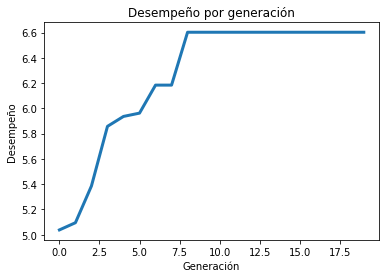

In [40]:
plot_fitness(gsf)

In [57]:
mejor = 0
for p in pop:
    if(p.fitness.values[0] >= mejor):
        solution = p
        mejor = p.fitness.values[0]

In [62]:
gsf[-1]

6.602205882352941

In [58]:
evaluarSolucion(solution)

La carga evaluada tiene:
	41.83% de utilidad por las materias de primeros ciclos llevadas.
	0.0% del total de las materias reprobadas del estudiante.
	75.0% de utilidad por cantidad ideal de materias del estudiante.
	0% de costo por sobreposición con las horas donde el estudiante no está disponible.
	75.0% de costo por el total de amplitud de horario.


In [59]:
obtenerDatosCarga(solution)

,clave,ciclos,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes
7,ID0161,1,Recursos de comunicación para la era digital,Zavala López / Erika Erendira,-,-,09:00-11:00,13:00-14:00,-
11,ID0206,2,Interconectividad en redes,Sansores Pérez / Candelaria Elizabeth,11:00-13:00,-,11:00-13:00,-,-
26,II0215,2,Electricidad y magnetismo,Casas De La Cruz / Rosa Guadalupe,14:00-16:00,-,-,16:00-18:00,-
32,DP0396,2,Identidad y cultura,Alavez San Pedro / Minerva,-,14:00-16:00,-,15:00-16:00,-
39,DP0498,3,Problemas de México,Manzo de León / Leonela Paola,20:00-22:00,-,20:00-21:00,-,-
50,ID0308,3,Análisis de grandes volúmenes de datos,Olivares González / Cyntya,09:00-11:00,-,-,09:00-11:00,-
52,DP0497,3,Problemas del mundo contemporáneo,Sánchez Novelo / Mariela de Jesús,-,18:00-20:00,-,-,20:00-21:00
56,ID3415,4,Cómputo ubicuo,Sansores Pérez / Candelaria Elizabeth,-,-,18:00-20:00,-,18:00-19:00


In [60]:
obtenerHorario(solution)

,Hora,Lunes,Martes,Miercoles,Jueves,Viernes
2,9:00-10:00,Análisis de grandes volúmenes de datos,-,Recursos de comunicación para la era digital,Análisis de grandes volúmenes de datos,-
3,10:00-11:00,Análisis de grandes volúmenes de datos,-,Recursos de comunicación para la era digital,Análisis de grandes volúmenes de datos,-
4,11:00-12:00,Interconectividad en redes,-,Interconectividad en redes,-,-
5,12:00-13:00,Interconectividad en redes,-,Interconectividad en redes,-,-
6,13:00-14:00,-,-,-,Recursos de comunicación para la era digital,-
7,14:00-15:00,Electricidad y magnetismo,Identidad y cultura,-,-,-
8,15:00-16:00,Electricidad y magnetismo,Identidad y cultura,-,Identidad y cultura,-
9,16:00-17:00,-,-,-,Electricidad y magnetismo,-
10,17:00-18:00,-,-,-,Electricidad y magnetismo,-
11,18:00-19:00,-,Problemas del mundo contemporáneo,Cómputo ubicuo,-,Cómputo ubicuo


## ========

In [45]:
recomendaciones = obtenerRecomendacionesUnicas(pop,0.1)

C:\Users\eddie\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [46]:
len(recomendaciones)

500

In [47]:
obtenerDesempeno(recomendaciones[0])

4.461601307189543

In [48]:
evaluarSolucion(recomendaciones[0])

La carga evaluada tiene:
	41.83% de utilidad por las materias de primeros ciclos llevadas.
	0.0% del total de las materias reprobadas del estudiante.
	75.0% de utilidad por cantidad ideal de materias del estudiante.
	0% de costo por sobreposición con las horas donde el estudiante no está disponible.
	75.0% de costo por el total de amplitud de horario.


In [49]:
obtenerDatosCarga(recomendaciones[0])

,clave,ciclos,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes
7,ID0161,1,Recursos de comunicación para la era digital,Zavala López / Erika Erendira,-,-,09:00-11:00,13:00-14:00,-
11,ID0206,2,Interconectividad en redes,Sansores Pérez / Candelaria Elizabeth,11:00-13:00,-,11:00-13:00,-,-
26,II0215,2,Electricidad y magnetismo,Casas De La Cruz / Rosa Guadalupe,14:00-16:00,-,-,16:00-18:00,-
32,DP0396,2,Identidad y cultura,Alavez San Pedro / Minerva,-,14:00-16:00,-,15:00-16:00,-
39,DP0498,3,Problemas de México,Manzo de León / Leonela Paola,20:00-22:00,-,20:00-21:00,-,-
50,ID0308,3,Análisis de grandes volúmenes de datos,Olivares González / Cyntya,09:00-11:00,-,-,09:00-11:00,-
52,DP0497,3,Problemas del mundo contemporáneo,Sánchez Novelo / Mariela de Jesús,-,18:00-20:00,-,-,20:00-21:00
56,ID3415,4,Cómputo ubicuo,Sansores Pérez / Candelaria Elizabeth,-,-,18:00-20:00,-,18:00-19:00


In [50]:
obtenerDatosCarga(solution)

,clave,ciclos,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes
7,ID0161,1,Recursos de comunicación para la era digital,Zavala López / Erika Erendira,-,-,09:00-11:00,13:00-14:00,-
11,ID0206,2,Interconectividad en redes,Sansores Pérez / Candelaria Elizabeth,11:00-13:00,-,11:00-13:00,-,-
26,II0215,2,Electricidad y magnetismo,Casas De La Cruz / Rosa Guadalupe,14:00-16:00,-,-,16:00-18:00,-
32,DP0396,2,Identidad y cultura,Alavez San Pedro / Minerva,-,14:00-16:00,-,15:00-16:00,-
39,DP0498,3,Problemas de México,Manzo de León / Leonela Paola,20:00-22:00,-,20:00-21:00,-,-
50,ID0308,3,Análisis de grandes volúmenes de datos,Olivares González / Cyntya,09:00-11:00,-,-,09:00-11:00,-
52,DP0497,3,Problemas del mundo contemporáneo,Sánchez Novelo / Mariela de Jesús,-,18:00-20:00,-,-,20:00-21:00
56,ID3415,4,Cómputo ubicuo,Sansores Pérez / Candelaria Elizabeth,-,-,18:00-20:00,-,18:00-19:00


# Coevolución cooperativa

In [35]:
def obtenerSimilitud(x,y):
    x_set = set(x)
    return sum(yi in x_set for yi in y)

In [36]:
def obtenerPesoPorSimilitud(representatives, sol):
    exp = 5
    maxSimilitud = max(obtenerSimilitud(r,sol) for r in representatives)
    
    
    return (9 - maxSimilitud) / 9

In [37]:
def obtenerDesempenoCoev(representatives,sol):
    desempeno = obtenerDesempeno(sol)
    return (desempeno * obtenerPesoPorSimilitud(representatives,sol),), desempeno

In [38]:
pesos = {
    "upcc": 2,    #Utilidad por cerrar ciclos
    "upmr": 1,    #Utilidad por materias reprobadas
    "upcm": 1,    #Utilidad por cantidad ideal de materias
    "cpdh": 2.5,  #Costo por disponibilidad de horario
    "cpah": 1.5,  #Costo por amplitud de horario
    "cphl": 1     #Costo por horas libres (no se está utilizando actualmente)
}

disponibilidadComoRestriccion = False
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
plan = plan_2016

kardex = obtenerKardex(190311499).query('periodo < 202201')
ofertaUtil = obtenerOfertaUtil(kardex,oferta)
cantidadMateriasIdeal = 7

In [39]:
verKardex()

Matricula: 190311499
Carrera: Ingeniería en Datos e Inteligencia Organizacional
Creditos: 240
Materias Reprobadas:


Periodo: 201903
Clave		Promedio	Nombre de asignatura
DP0194		9.0		Desarrollo de habilidades del pensamiento
ID0102		10.0		Física clásica
IT0161		9.0		Sistemas operativos POSIX
IL0102		10.0		Teoría general de sistemas
DP0191		10.0		Taller de interacción grupal y competencias comunicativas
II0106		10.0		Cálculo diferencial
IT0101		10.0		Algoritmos y estructura de datos
LI1104		10.0		Nivel 4 Inglés


Periodo: 202001
Clave		Promedio	Nombre de asignatura
IT0103		10.0		Introducción a las redes
II0209		9.0		Cálculo integral
IT0104		9.0		Matemáticas discretas
IT0264		10.0		Introducción a los sistemas de información
ID0101		9.0		Diseño de patrones para datos estructurados
ID0103		10.0		Organización y diseño de computadoras
TA0011		10.0		Teatro
DP0193		10.0		Taller de redacción profesional
LI0109		10.0		Tópicos selectos de inglés


Periodo: 202002
Clave		Promedio	Nombre de asignat

In [40]:
num_species = 10
pop_per_species = 500

species = [toolbox.population(n = pop_per_species) for _ in range(num_species)]
representatives = [random.choice(species[i]) for i in range(num_species)]

In [41]:
ngen = 25
n_parents = 6
num_offspring = len(species[0]) - n_parents
saturation = [0] * num_species
saturation_threshold = 10
generation_solution_fitness = [[],[],[],[],[],[],[],[],[],[]]
generation_solution_previous_fitness = [0] * num_species

#Evaluación inicial
for s,s_i in zip(species,range(num_species)):
    maxDes = 0
    for i in s:
        desCoev,des = obtenerDesempenoCoev(representatives,i)
        maxDes = max(maxDes,des)
        i.fitness.values = desCoev
    generation_solution_fitness[s_i].append(maxDes)

for gen in range(ngen):
    print("Generación: " + str(gen))
    
    for (s, s_index) in zip(species,range(len(species))):
        if(saturation[s_index] >= saturation_threshold):
            continue
        #Selección de padres (Elitismo)
        parents = toolbox.select(s, n_parents)
        parents = toolbox.clone(parents)
        offspring = []

        #Cruzamiento
        while len(offspring) < num_offspring:
            for p1,p2 in zip(parents[::2],parents[1::2]):
                child1, child2 = toolbox.mate(p1,p2)
                offspring.append(creator.carga(child1.copy()))
                offspring.append(creator.carga(child2.copy()))

        #Mutacion
        for i in range(len(offspring)):
            toolbox.mutate(offspring[i])
            
        #Remplazamiento
        s = offspring + parents
        s = s.copy()

        # Get the representatives excluding the current species
        r = representatives[:i] + representatives[i+1:]
        desMax = 0
        for ind in s:
            # Evaluate and set the individual fitness
            desCoev,des = obtenerDesempenoCoev(r,ind)
            ind.fitness.values = desCoev
            desMax = max(desMax,des)
        generation_solution_fitness[s_index].append(desMax)
        
        
        if(desMax == generation_solution_previous_fitness[s_index]):
            saturation[s_index] += 1
        else:
            generation_solution_previous_fitness[s_index] = desMax
            saturation[s_index] = 0
        print('\tEspecie: ' + str(s_index) + ', ' + str(desMax))

        # Select the individuals
        species[s_index] = s.copy()
        representatives[s_index] = toolbox.select(s,1)[0]   # Best selection

Generación: 0
	Especie: 0, 7.050595238095238
	Especie: 1, 7.056547619047619
	Especie: 2, 6.892857142857142
	Especie: 3, 6.681547619047619
	Especie: 4, 6.708333333333333
	Especie: 5, 6.8601190476190474
	Especie: 6, 7.086309523809524
	Especie: 7, 7.056547619047619
	Especie: 8, 7.050595238095238
	Especie: 9, 7.053571428571429
Generación: 1
	Especie: 0, 7.428571428571429
	Especie: 1, 6.717261904761905
	Especie: 2, 7.238095238095238
	Especie: 3, 7.053571428571429
	Especie: 4, 6.717261904761905
	Especie: 5, 6.705357142857142
	Especie: 6, 7.050595238095238
	Especie: 7, 7.050595238095238
	Especie: 8, 7.050595238095238
	Especie: 9, 7.241071428571429
Generación: 2
	Especie: 0, 7.086309523809524
	Especie: 1, 6.678571428571429
	Especie: 2, 7.428571428571429
	Especie: 3, 6.714285714285714
	Especie: 4, 6.866071428571429
	Especie: 5, 6.872023809523809
	Especie: 6, 7.241071428571429
	Especie: 7, 7.050595238095238
	Especie: 8, 7.238095238095238
	Especie: 9, 7.241071428571429
Generación: 3
	Especie: 0, 

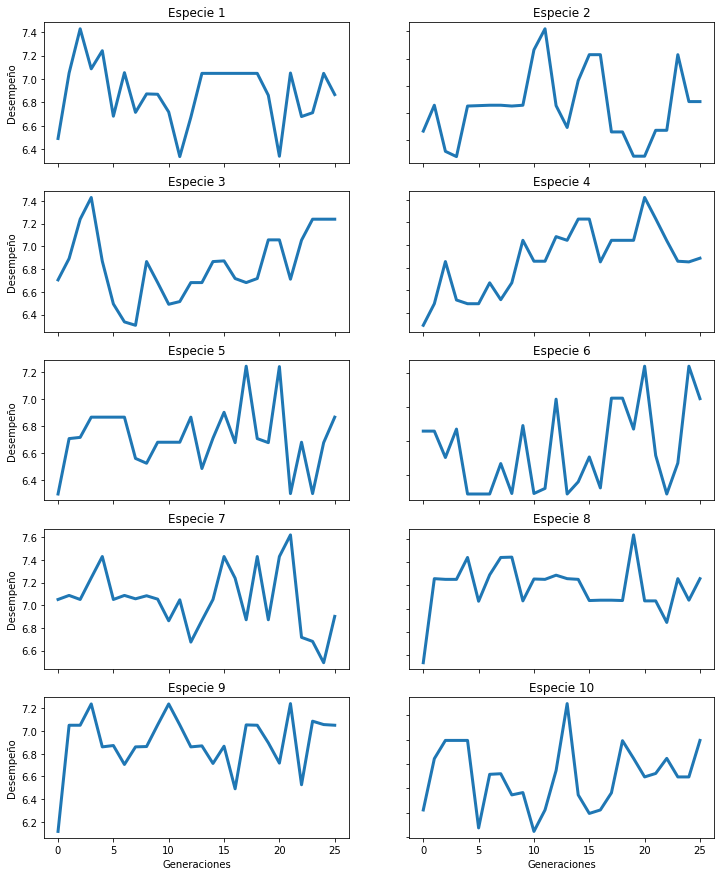

In [43]:
fig, axs = plt.subplots(5,2,figsize=(12,15))
counter = 0

for i in range(5):
    for j in range(2):
        axs[i,j].plot(generation_solution_fitness[counter], linewidth=3)
        axs[i,j].set_title('Especie ' + str(counter+1))
        counter += 1

for ax in axs.flat:
    ax.set(xlabel='Generaciones', ylabel='Desempeño')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [45]:
for gsf in generation_solution_fitness:
    print(gsf[-1])

6.866071428571429
7.083333333333333
7.238095238095238
7.083333333333333
6.866071428571429
7.050595238095238
6.901785714285714
7.056547619047619
7.050595238095238
7.241071428571429


In [417]:
for s in species:
    for ind in s:
        ind.fitness.values = obtenerDesempeno(ind),

In [418]:
recomendaciones = []
for s in species:
    recomendaciones.append(toolbox.select(s,1)[0])

In [419]:
for r in recomendaciones:
    print(obtenerDesempeno(r))

7.428571428571429
7.056547619047619
7.053571428571429
7.053571428571429
6.681547619047619
6.5148809523809526
6.681547619047619
7.053571428571429
7.086309523809524
7.056547619047619


In [420]:
for x in range(10):
    print(obtenerPesoPorSimilitud(recomendaciones[:x]+recomendaciones[x+1:],recomendaciones[x]))

0.3333333333333333
0.4444444444444444
0.4444444444444444
0.4444444444444444
0.4444444444444444
0.4444444444444444
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.3333333333333333


In [425]:
pop[0]

[57, 60, 8, 50, 33, 18, 40, 40, 23]

In [432]:
obtenerDesempeno(representatives[2])

5.619047619047619

In [434]:
obtenerDesempeno(species[0][0])

6.336309523809524